In [1]:
import numpy as np
import healpy as hp
import astropy.io.fits as pyfits
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('~/latex-cm.mplstyle')

import seaborn as sns
colors = sns.color_palette('colorblind')

In [2]:
# load in many cos angle version
filename = '/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/expacs_share/parma_cpp_edit/AngOutCsv/SpaceportTucson_Arizona_2025_8_31_alt30000m.csv'
location = 'tucson'
date = '2025_8_31'

!mkdir -p {location}_{date}_maps/gifs
!mkdir -p {location}_{date}_maps/fits
!mkdir -p {location}_{date}_maps/sim

maps_dir = f'/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/{location}_{date}_maps'

In [3]:
df = pd.read_csv(filename)

In [4]:
def make_flux_map(nside, df, particle, energy):
    _df = df.query('particle == "{}" & energy == {}'.format(particle, energy))
    costhetas = _df['costheta'].values
    delta_costheta = 2.0/(len(costhetas) - 1)
    # print(delta_costheta)
    fluxes = _df['flux'].values # /cm2/s/MeV/sr

    npix = hp.nside2npix(nside)
    flux_map = np.zeros(npix)

    for ipix in range(npix):
        ang = hp.pix2ang(nside, ipix, nest=False)
        costheta = np.cos(ang[0])

        flux = 0
        if costheta >= 1.0 - delta_costheta:
            flux = fluxes[-2]
        else:
            index_costheta = int((costheta + 1)/delta_costheta)
            fraction = (costheta + 1)/delta_costheta - index_costheta
            flux = (1.0 - fraction) * fluxes[index_costheta] + fraction * fluxes[index_costheta + 1]

        flux_map[ipix] = flux # /cm2/s/MeV/sr

    # if do_multi_solid_angle:
    #     flux_map *= hp.nside2pixarea(nside) # /cm2/s/MeV/sr -> /cm2/s/MeV

    # if use_unit_keV:
    # flux_map /= 1e3 # /MeV -> /keV

    return flux_map

In [5]:
particle_dict = {'neutro':'Neutron', 'proton':'Proton', 'he---4':'Helium-4', 'muplus':'$\\mu^+$', 'mumins': '$\\mu^-$', 'electr':'Electron', 'positr':'Positron', 'photon': 'Photon'}

# start by previewing one particle
particle = 'photon'
particle_name = particle_dict[particle]

In [6]:
_df = df.query('particle == "{}"'.format(particle))
energies = np.sort(np.unique(_df['energy']))
print('# of Energies:', len(energies))
_df

# of Energies: 80


,particle,energy,costheta,flux,year,month,day,lat(deg),lon(deg),alti(m),g
62620,photon,0.011294,-1.00,1.590146e-02,2025,8,31,32.0852,110.943,30000,10
62621,photon,0.011294,-0.98,1.601375e-02,2025,8,31,32.0852,110.943,30000,10
62622,photon,0.011294,-0.96,1.612775e-02,2025,8,31,32.0852,110.943,30000,10
62623,photon,0.011294,-0.94,1.624353e-02,2025,8,31,32.0852,110.943,30000,10
62624,photon,0.011294,-0.92,1.636115e-02,2025,8,31,32.0852,110.943,30000,10
...,...,...,...,...,...,...,...,...,...,...,...
70695,photon,897160.000000,0.92,1.533682e-12,2025,8,31,32.0852,110.943,30000,10
70696,photon,897160.000000,0.94,1.513895e-12,2025,8,31,32.0852,110.943,30000,10
70697,photon,897160.000000,0.96,1.493957e-12,2025,8,31,32.0852,110.943,30000,10
70698,photon,897160.000000,0.98,1.473847e-12,2025,8,31,32.0852,110.943,30000,10


In [7]:
nside = 32

In [8]:
all_flux_maps = []
# for each energy bin
for i in range(len(energies)):
    # run make_flux_map for each energy bin
    flux_map = make_flux_map(nside, df, particle, energies[i])
    all_flux_maps.append(flux_map)

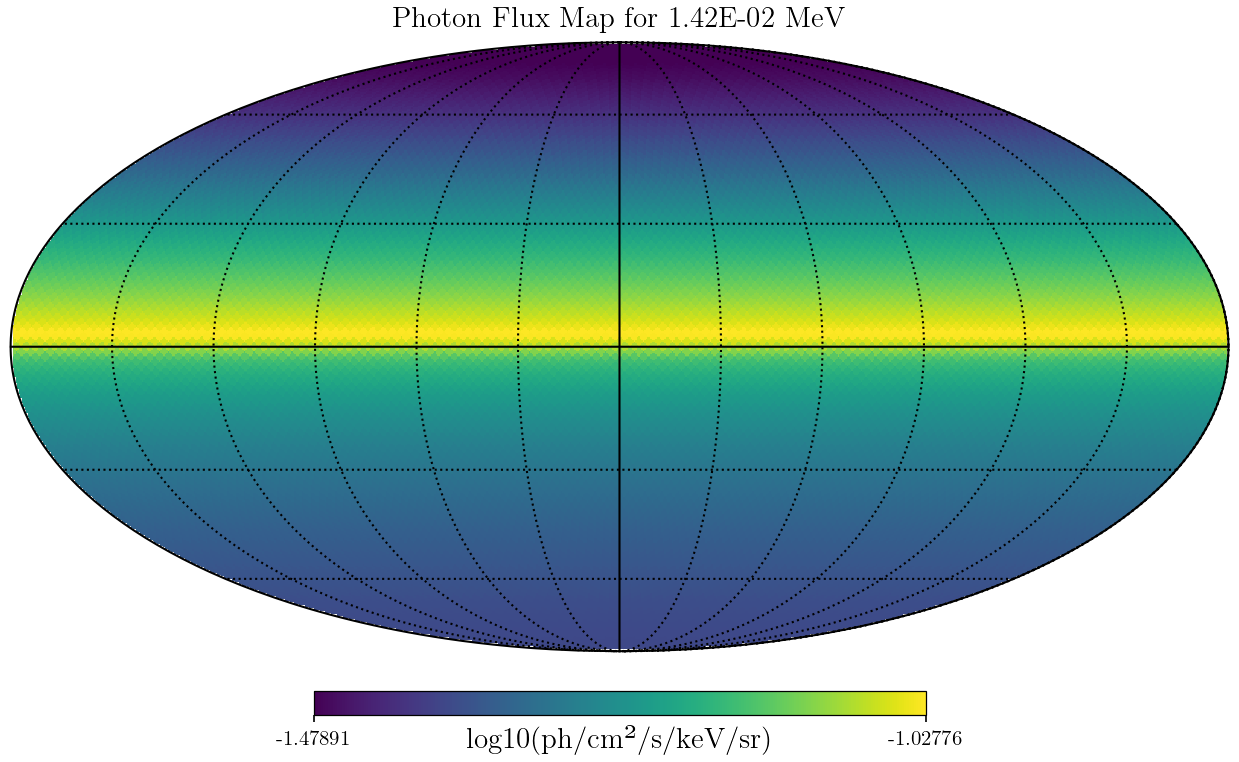

In [9]:
energy_bin = 1
hp.mollview(
    np.log10(all_flux_maps[energy_bin]),
    title=f"{particle_name} Flux Map for {energies[energy_bin]:.2E} MeV",
    unit="log10(ph/cm²/s/keV/sr)"
)
hp.graticule()
plt.show()

In [10]:
from ipywidgets import interact, IntSlider

# all_flux_maps: shape (N_energy, N_pix)
# energies: array-like of length N_energy (MeV)

def show_map(bin_idx):
    hp.mollview(
        np.log10(np.asarray(all_flux_maps[bin_idx])),
        title=f"{particle_name} Flux Map for {energies[bin_idx]:.2E} MeV",
        unit="log10(ph/cm²/s/MeV/sr)"
    )
    hp.graticule()
    plt.show()

interact(
    show_map,
    bin_idx=IntSlider(min=0, max=len(energies)-1, step=1, value=min(10, len(energies)-1), description="Energy bin")
)

interactive(children=(IntSlider(value=10, description='Energy bin', max=79), Output()), _dom_classes=('widget-…

<function __main__.show_map(bin_idx)>

In [11]:
# # loop through all particles and produce animations
# fps = 5
# use_log10 = True

# for particle in particle_dict.keys():
#     _df = df.query('particle == "{}"'.format(particle))

#     particle_name = particle_dict[particle]

#     energies = np.sort(np.unique(_df['energy']))
#     N = len(energies)
    
#     all_flux_maps = []
#     for i in range(N):
#         # run make_flux_map for each energy bin
#         flux_map = make_flux_map(nside, df, particle, energies[i])
#         all_flux_maps.append(flux_map)

#     fig = plt.figure(figsize=(8, 5))

#     def draw_frame(i):
#         plt.clf()
#         data = np.asarray(all_flux_maps[i])
#         if use_log10:
#             data = np.log10(np.maximum(data, 1e-30))
#         hp.mollview(
#             data,
#             # min=vmin_log if use_log10 else 10**vmin_log,
#             # max=vmax_log if use_log10 else 10**vmax_log,
#             title=f"{particle_name} Flux Map for {energies[i]:.2E} MeV",
#             unit="log10(1/cm²/s/MeV/sr)" if use_log10 else "1/cm²/s/MeV/sr",
#             fig=fig.number
#         )
#         hp.graticule()

#     step = 2  # keep every 2nd frame
#     ani = animation.FuncAnimation(fig, draw_frame, frames=range(0, N, step), interval=1000 / fps)

#     file = f"{location}_{date}_maps/gifs/{particle}_maps.gif"
#     ani.save(file, writer="pillow", fps=fps*1.5, dpi=200)

#     plt.close(fig)
#     print(f"Saved animation to {file}")


## Run mk_healpix_map.py

In [12]:
# # convert to healpix maps using mk_healpix_map.py
# for particle in particle_dict.keys():
#     output =f'{location}_{date}_maps/fits/{location}_{date}_{particle}.fits'
#     !python /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/expacs_share/fitsfile_20221207/mk_healpix_map.py "{filename}" "{output}" "{particle}"

## Validate HEALPix Maps From mk_healpix_map.py

In [13]:
particle = 'photon'
fits_file = f'{maps_dir}/fits/{location}_{date}_{particle}.fits'

In [14]:
all_maps = hp.read_map(fits_file, field=None)  # list of maps

header = pyfits.open(fits_file)[1].header

n_map = header["TFIELDS"]
nside = header["NSIDE"]
map_names = []
for i in range(n_map):
    map_names.append(header["TTYPE{}".format(i+1)])

print(header)

def show_map(bin_idx):
    hp.mollview(
        np.log10(all_maps[bin_idx]), 
        title = map_names[bin_idx], 
        unit = header["TUNIT{}".format(bin_idx+1)], 
        rot = (0, 0)
    )
    hp.graticule()
    plt.show()

interact(
    show_map,
    bin_idx=IntSlider(min=0, max=len(all_maps)-1, step=1, value=min(10, len(all_maps)-1), description="Energy bin")
)

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =               655360 / length of dimension 1                          NAXIS2  =                   12 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                   80 / number of table fields                         TTYPE1  = 'map_E_0.011294_MeV'                                                  TFORM1  = '1024D   '                                                            TUNIT1  = 'ph/cm2/MeV/sr/s'                                                     TTYPE2  = 'map_E_0.014219_MeV'                                                  TFORM2  = '1024D   '                    

interactive(children=(IntSlider(value=10, description='Energy bin', max=79), Output()), _dom_classes=('widget-…

<function __main__.show_map(bin_idx)>

In [15]:
pyfits.info(fits_file)

Filename: /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/fits/tucson_2025_8_31_photon.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  ALLSKYMAP     1 BinTableHDU    347   12R x 80C   [1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D, 1024D]   
  2  EnergyList    1 BinTableHDU     12   80R x 1C   [D]   


In [16]:
# header = pyfits.open(fits_file)[1].header
from astropy.table import Table
t = Table.read(fits_file, hdu=2)

t.show_in_notebook()
# with pyfits.open(fits_file) as hdul:
#     hdu = hdul[1]
#     print(hdu.columns)
#     # print(len(hdul))
#     # print(hdu.header['ENE140'])
#     # print(hdu.header)      # check NSIDE, ORDERING, etc.
#     # print(hdu.columns)     # columns like 'I', 'Q', 'U', 'PIXEL', etc.

idx,Energy
,keV
0,0.011294
1,0.014219
2,0.017901
3,0.022536
4,0.028371
5,0.035717
6,0.044965
7,0.056607
8,0.071264


## Run GramsSky

In [17]:
# generate command line call to run GramsSky
options_file = '/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/occupancy_grams.xml'
output_hepmc3 =f'{maps_dir}/sim/{location}_{particle}.hepmc3'

# run gramssky in a terminal
command = f'./gramssky {options_file} --MapEnergyBandsFile {fits_file} -o {output_hepmc3}'
print(command)

./gramssky /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/occupancy_grams.xml --MapEnergyBandsFile /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/fits/tucson_2025_8_31_photon.fits -o /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/sim/tucson_photon.hepmc3


In [18]:
import pyhepmc

n_events = 0
with pyhepmc.open(output_hepmc3, "r") as f:
    for i, evt in enumerate(f):
        # Units are per event in HepMC3
        # print("Units:", evt.momentum_unit, evt.length_unit)
        print("Event number:", evt.event_number)
        print("Weights:", evt.weights)

        print("Num particles:", len(evt.particles))
        print("Num vertices:", len(evt.vertices))

        # Show a few particles
        for p in list(evt.particles)[:1]:
            mom = p.momentum
            print(
                f" pid={p.pid:6d} status={p.status:3d}"
                f" px={mom.px:.3g} py={mom.py:.3g} pz={mom.pz:.3g} E={mom.e:.3g}"
            )
            print('----------------------------')
        n_events += 1
        if i >= 10:  # preview first 10 events
            break

print("Previewed events:", n_events)


Event number: 0
Weights: []
Num particles: 2
Num vertices: 1
 pid=    22 status=  1 px=-0.04 py=-0.0111 pz=-0.0371 E=0.0557
----------------------------
Event number: 1
Weights: []
Num particles: 2
Num vertices: 1
 pid=    22 status=  1 px=0.0154 py=-0.125 pz=0.113 E=0.169
----------------------------
Event number: 2
Weights: []
Num particles: 2
Num vertices: 1
 pid=    22 status=  1 px=1.49e-14 py=81.3 pz=-5.09 E=81.5
----------------------------
Event number: 3
Weights: []
Num particles: 2
Num vertices: 1
 pid=    22 status=  1 px=-0.161 py=0.213 pz=0.394 E=0.475
----------------------------
Event number: 4
Weights: []
Num particles: 2
Num vertices: 1
 pid=    22 status=  1 px=160 py=107 pz=36.7 E=195
----------------------------
Event number: 5
Weights: []
Num particles: 2
Num vertices: 1
 pid=    22 status=  1 px=-0.057 py=0.0901 pz=-0.055 E=0.12
----------------------------
Event number: 6
Weights: []
Num particles: 2
Num vertices: 1
 pid=    22 status=  1 px=1.1 py=1.34 pz=0.182 

In [19]:
def theta_phi(px, py, pz):
    p = np.sqrt(px*px + py*py + pz*pz)
    if p == 0: 
        return None, None
    costh = pz/p
    th = np.arccos(np.clip(costh, -1.0, 1.0))
    ph = np.mod(np.arctan2(py, px), 2*np.pi)
    return th, ph

E_list, th_list, ph_list, pid_counts = [], [], [], {}

with pyhepmc.open(output_hepmc3, "r") as f:
    for i, evt in enumerate(f):
        for p in evt.particles:
            if p.status != 1:  # typical “final-state” convention
                continue
            px, py, pz, E = p.momentum.px, p.momentum.py, p.momentum.pz, p.momentum.e
            E_list.append(E)
            th, ph = theta_phi(px, py, pz)
            if th is not None:
                th_list.append(th); ph_list.append(ph)
            pid_counts[p.pid] = pid_counts.get(p.pid, 0) + 1

print("Number of events:", sum(pid_counts.values()))
print("Top PIDs:", sorted(pid_counts.items(), key=lambda x: -x[1])[:10])

Number of events: 10000
Top PIDs: [(22, 10000)]


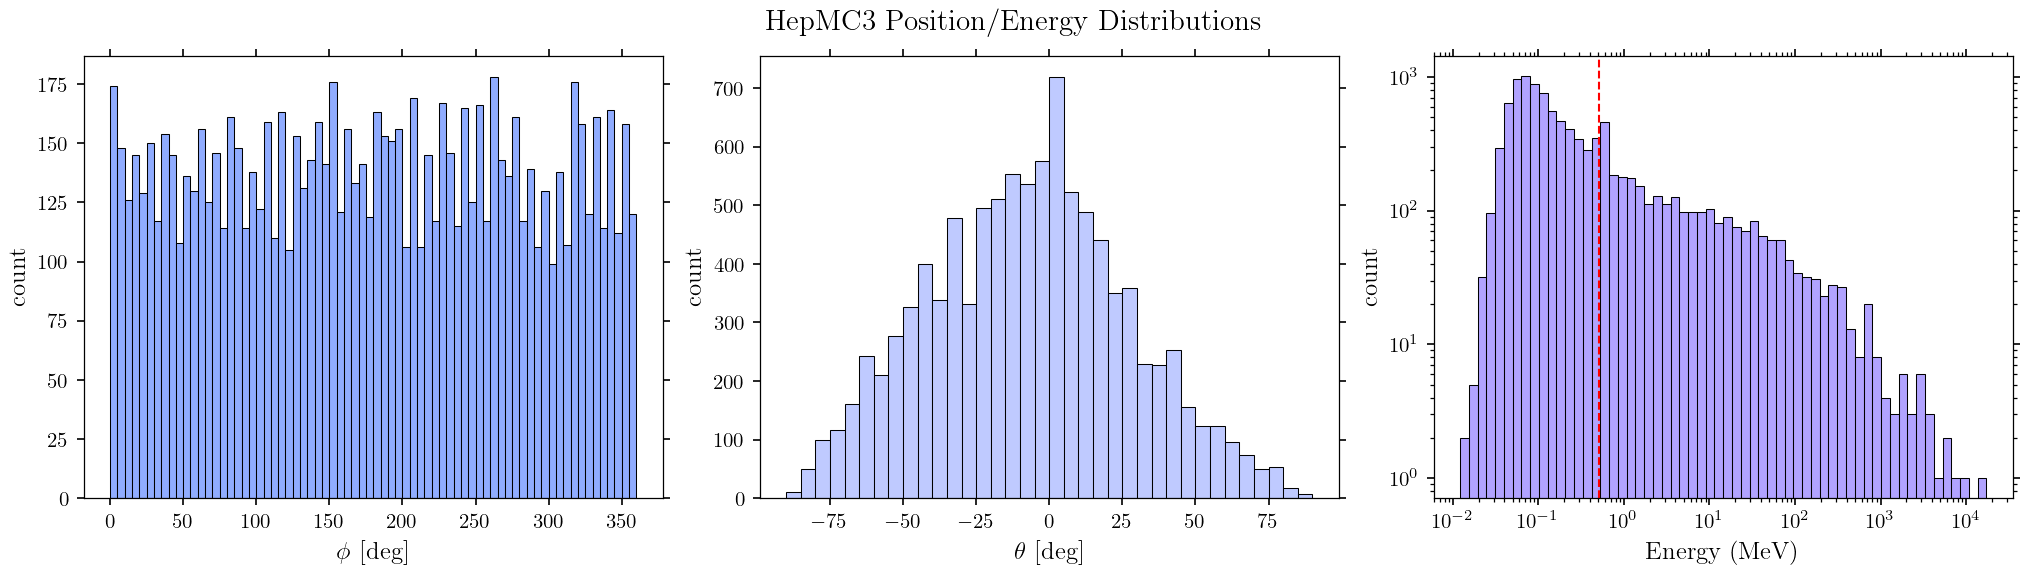

In [20]:
# convert angles to degrees
ph_deg = np.degrees(np.mod(ph_list, 2*np.pi))
th_deg = np.degrees(th_list) - 90

fig, axes = plt.subplots(1, 3, figsize=(13.5, 3.8), constrained_layout=True)

# phi
axes[0].hist(ph_deg, bins=72, range=(0.0, 360.0), color="#90ACFF", edgecolor='black', lw=0.5)
axes[0].set_xlabel("$\\phi$ [deg]")
axes[0].set_ylabel("count")

# Theta (degrees)
axes[1].hist(th_deg, bins=36, range=(-90.0, 90.0), color="#BFCAFF", edgecolor='black', lw=0.5)
axes[1].set_xlabel("$\\theta$ [deg]")
axes[1].set_ylabel("count")

# Energy with log-scaled x-axis and log-spaced bins
E = np.asarray(E_list)
Epos = E[E > 0]
emin = max(np.min(Epos), 1e-12) if Epos.size else 1e-12
emax = np.max(Epos) if Epos.size else 1.0
bins = np.logspace(np.log10(emin), np.log10(emax), 61)

axes[2].hist(Epos, bins=bins, color="#9886FFC1", edgecolor='black', lw=0.5)
axes[2].set_xscale("log")
axes[2].set_yscale("log")
axes[2].set_xlabel("Energy (MeV)")
axes[2].set_ylabel("count")
axes[2].axvline(0.511, color='red', linestyle='--', lw=1)

fig.suptitle('HepMC3 Position/Energy Distributions', fontsize=14)

plt.show()


## Run GramsG4

In [45]:
# generate command line call to run GramsG4
output_g4 =f'{maps_dir}/sim/{location}_{particle}_g4.root'

command = f'./gramsg4 {options_file} -i {output_hepmc3} -o {output_g4}'
print(command)

./gramsg4 /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/occupancy_grams.xml -i /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/sim/tucson_photon.hepmc3 -o /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/sim/tucson_photon_g4.root


In [46]:
import ROOT
ROOT.gSystem.Load("/nevis/tehanu/data/st3624/software/GRAMS/GramsSim-work/libDictionary.so")

# open the input file and access the ElecSim tree 
inputFile = ROOT.TFile(output_g4)
tree = ROOT.gDirectory.Get('gramsg4')

# # add friend trees
# tree.AddFriend("ReadoutSim","../GramsSim-work/gramsreadoutsim.root")
# tree.AddFriend("DetSim","../GramsSim-work/gramsdetsim.root")
# tree.AddFriend("gramsg4","../GramsSim-work/gramsg4.root")

In [47]:
# intialize energies_dict; key: event ID, value: total energy deposition
energies_dict = {}
theta_list = []
phi_list = []

# loop through tree and extract energy of primary particles for every event
for entry in tree:
    event = tree.EventID.Index()
    # print("Event ID: ", event)

    energies_dict[event] = 0
    primaries = []
    for trackID, track in tree.TrackList:
        # print(track.PDGCode())
        if track.Process() == "Primary":
            # print(track.Process())
            trajectory = track.Trajectory()
            primary_energy = trajectory[0].momentum.E()
            px, py, pz = trajectory[0].momentum.px(), trajectory[0].momentum.py(), trajectory[0].momentum.pz()
            theta, phi = theta_phi(px, py, pz)
            # print(primary_energy)
            energies_dict[event]=primary_energy
            theta_list.append(theta)
            phi_list.append(phi)

    # print total energy for given event
    # print("Energy for event ", tree.EventID.Index(), ": ", energies_dict[event])


energies = list(energies_dict.values())

# with open("energies.txt", "w") as f:
#     for energy in energies:
#         f.write(str(energy) + "\n")


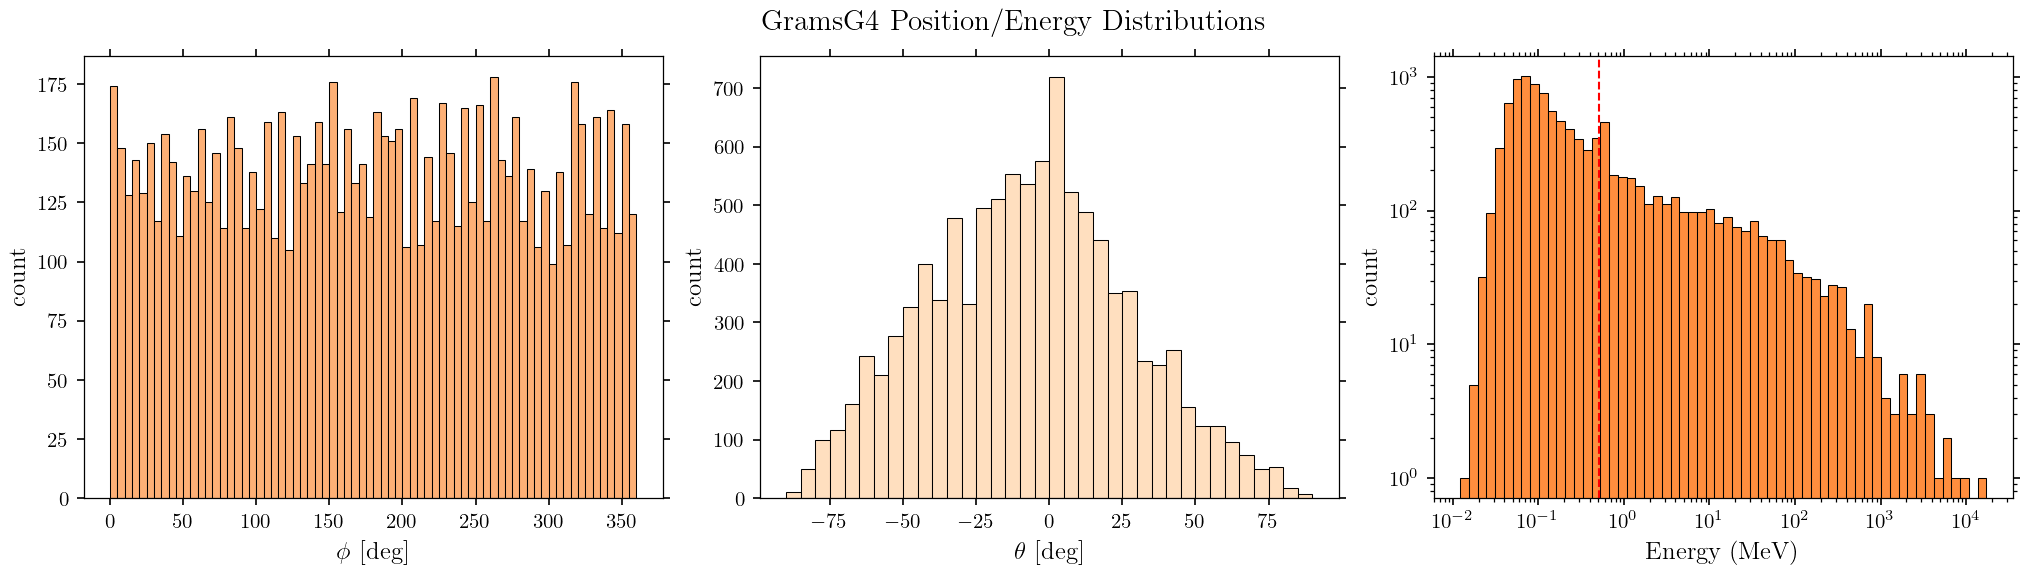

In [48]:
# convert angles to degrees
phi_deg = np.degrees(np.mod(phi_list, 2*np.pi))
theta_deg = np.degrees(theta_list) - 90

fig, axes = plt.subplots(1, 3, figsize=(13.5, 3.8), constrained_layout=True)

# phi
axes[0].hist(phi_deg, bins=72, range=(0.0, 360.0), color="#FDB076", edgecolor='black', lw=0.5)
axes[0].set_xlabel("$\\phi$ [deg]")
axes[0].set_ylabel("count")

# Theta (degrees)
axes[1].hist(theta_deg, bins=36, range=(-90.0, 90.0), color="#FFDFBF", edgecolor='black', lw=0.5)
axes[1].set_xlabel("$\\theta$ [deg]")
axes[1].set_ylabel("count")

# Energy with log-scaled x-axis and log-spaced bins
E = np.asarray(energies)
Epos = E[E > 0]
emin = max(np.min(Epos), 1e-12) if Epos.size else 1e-12
emax = np.max(Epos) if Epos.size else 1.0
bins = np.logspace(np.log10(emin), np.log10(emax), 61)

axes[2].hist(Epos, bins=bins, color="#FF6A00C1", edgecolor='black', lw=0.5)
axes[2].set_xscale("log")
axes[2].set_yscale("log")
axes[2].set_xlabel("Energy (MeV)")
axes[2].set_ylabel("count")
axes[2].axvline(0.511, color='red', linestyle='--', lw=1)

fig.suptitle('GramsG4 Position/Energy Distributions', fontsize=14)

plt.show()


In [49]:
print(np.asarray(phi_list)-np.asarray(ph_list))
print(np.asarray(theta_list)-np.asarray(th_list))
print(np.asarray(energies)-np.asarray(E_list))

[0. 0. 0. ... 0. 0. 0.]
[ 0.00000000e+00 -2.22044605e-16 -2.22044605e-16 ...  1.11022302e-16
  0.00000000e+00  0.00000000e+00]
[0.00000000e+00 2.77555756e-17 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


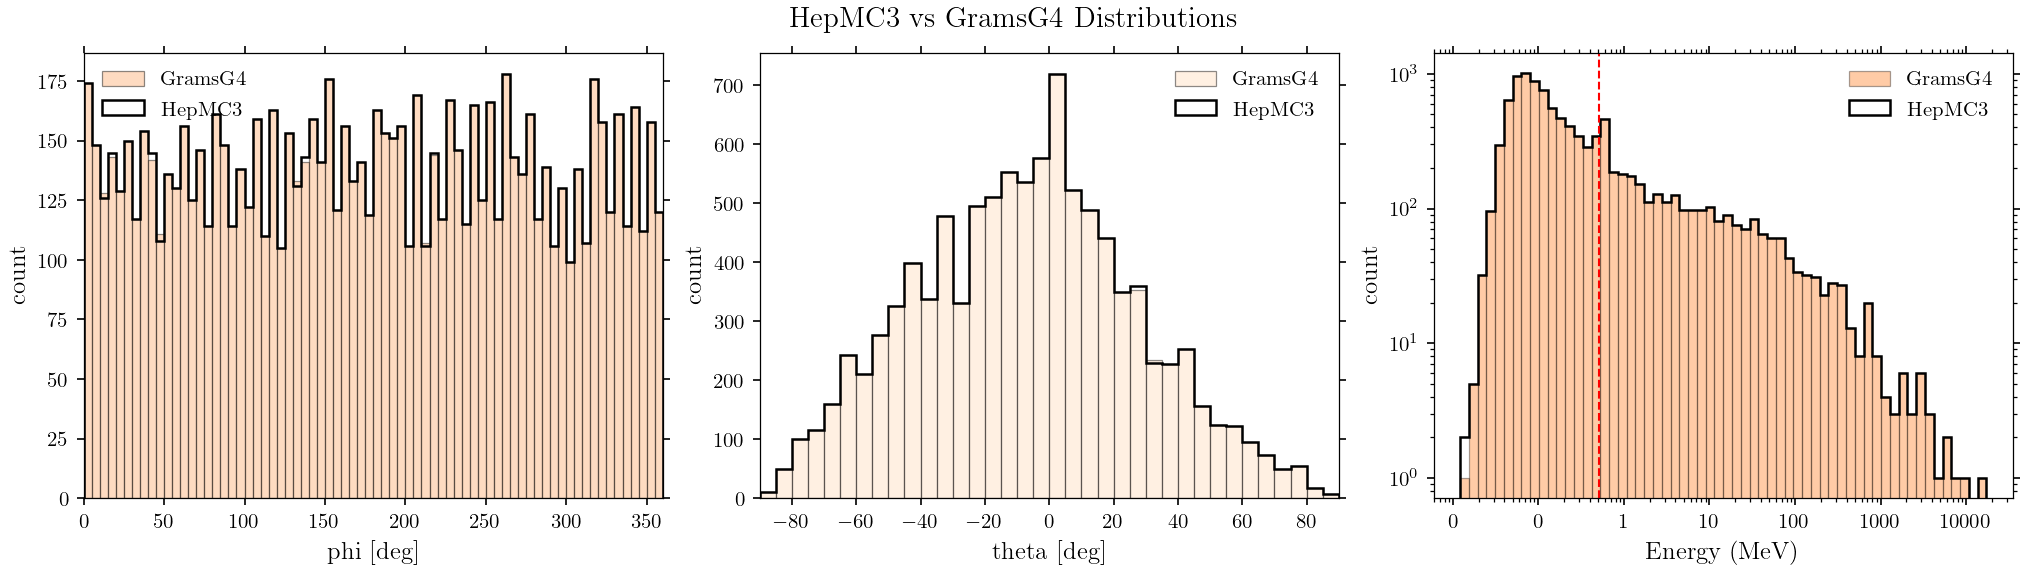

In [56]:
# this block is AI-generated
from matplotlib.ticker import ScalarFormatter

# Convert angles to degrees
phi_deg   = np.degrees(np.mod(phi_list, 2*np.pi))
theta_deg = np.degrees(theta_list) - 90

ph_deg = np.degrees(np.mod(ph_list, 2*np.pi))
th_deg = np.degrees(th_list) - 90

fig, axes = plt.subplots(1, 3, figsize=(13.5, 3.8), constrained_layout=True)

# --- Phi overlay ---
bins_phi = np.linspace(0.0, 360.0, 73)  # 72 bins
axes[0].hist(phi_deg, bins=bins_phi,
             alpha=0.45, color="#FDB076", edgecolor="black", lw=0.6, label="GramsG4")
axes[0].hist(ph_deg,  bins=bins_phi, histtype="step",
             color="black", lw=1.2, label="HepMC3")
axes[0].set_xlabel("phi [deg]")
axes[0].set_ylabel("count")
axes[0].set_xlim(0, 360)
axes[0].legend(frameon=False)

# --- Theta overlay ---
bins_theta = np.linspace(-90.0, 90.0, 37)  # 36 bins
axes[1].hist(theta_deg, bins=bins_theta,
             alpha=0.45, color="#FFDFBF", edgecolor="black", lw=0.6, label="GramsG4")
axes[1].hist(th_deg,    bins=bins_theta, histtype="step",
             color="black", lw=1.2, label="HepMC3")
axes[1].set_xlabel("theta [deg]")
axes[1].set_ylabel("count")
axes[1].set_xlim(-90, 90)
axes[1].legend(frameon=False)

# --- Energy overlay (log x, optional log y) ---
E_g4    = np.asarray(energies)
E_g4    = E_g4[E_g4 > 0]
E_hepmc = np.asarray(E_list)
E_hepmc = E_hepmc[E_hepmc > 0]

if E_g4.size and E_hepmc.size:
    emin = min(E_g4.min(), E_hepmc.min())
    emax = max(E_g4.max(), E_hepmc.max())
else:
    emin, emax = (1e-12, 1.0)

bins_E = np.logspace(np.log10(max(emin, 1e-12)), np.log10(emax), 61)

axes[2].hist(E_g4,   bins=bins_E,
             alpha=0.35, color="#FF6A00C1", edgecolor="black", lw=0.6, label="GramsG4")
axes[2].hist(E_hepmc, bins=bins_E, histtype="step",
             color="black", lw=1.2, label="HepMC3")

axes[2].set_xscale("log")
axes[2].set_yscale("log")
axes[2].set_xlabel("Energy (MeV)")
axes[2].set_ylabel("count")
axes[2].axvline(0.511, color="red", linestyle="--", lw=1)
axes[2].xaxis.set_major_formatter(ScalarFormatter())
axes[2].legend(frameon=False)

fig.suptitle("HepMC3 vs GramsG4 Distributions", fontsize=14)
plt.show()


## Run GramsDetSim

In [57]:
# generate command line call to run GramsDetSim
output_det =f'{maps_dir}/sim/{location}_{particle}_det.root'
    
command = f'./gramsdetsim {options_file} -i {output_g4} -o {output_det}'
print(command)

./gramsdetsim /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/occupancy_grams.xml -i /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/sim/tucson_photon_g4.root -o /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/sim/tucson_photon_det.root
